# Systèmes de Recommandation avec la base de données MovieLens 1M 

## 1). Importer en nettoyer le jeu de données MovieLens 1M

Dans cette section, nous utilisons le jeu de données **MovieLens 1M**, une base de données publique contenant **1 million de notations** de films réalisées par environ **6 000 utilisateurs** sur plus de **3 900 films**.

Ces données sont largement utilisées pour l’expérimentation et la recherche dans les **systèmes de recommandation** basés sur les filtrages **collaboratif** et **content-based** que nous allons implémenter dans cette section du projet.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from helper_functions import download_movielens, merge_dfs, clean_df, search_films

# Set Global Chart Style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [2]:
# Downloading the data (this can take up to 5 minutes to run)
if __name__ == "__main__":
    download_movielens()

Téléchargement vers /home/onyxia/work/projet_python_films/part2_recommenders /ml-1m.zip...
Téléchargement terminé.
Extraction dans /home/onyxia/work/projet_python_films/part2_recommenders /ml-1m...
Extraction terminée.


In [3]:
# Preparing the dataframe (by merging user info, movie info and ratings into 1 df)
df_users = merge_dfs()
df_users.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [4]:
# Cleaning up the df (splitting titles and years + transforming Genres string into list + making Gender binary)
df_users=clean_df(df_users)
df_users.head()

,UserID,MovieID,Rating,Gender,Age,Occupation,Zip-code,Title,Genres,Year
0,1,1193,5,1,1,10,48067,One Flew Over the Cuckoo's Nest,[Drama],1975.0
1,1,661,3,1,1,10,48067,James and the Giant Peach,"[Animation, Children's, Musical]",1996.0
2,1,914,3,1,1,10,48067,My Fair Lady,"[Musical, Romance]",1964.0
3,1,3408,4,1,1,10,48067,Erin Brockovich,[Drama],2000.0
4,1,2355,5,1,1,10,48067,"Bug's Life, A","[Animation, Children's, Comedy]",1998.0


## 2). Visualiser les données (Exploratory Data Analysis)

### Démographie et utilisateurs 

In [5]:
# Nombre total d'utilisateurs
total_users = df_users["UserID"].nunique()
print("Total number of unique users:", total_users)

Total number of unique users: 6040


Gender
Male      4331
Female    1709
Name: UserID, dtype: int64
 
There are 71.70529801324503% men in the dataset


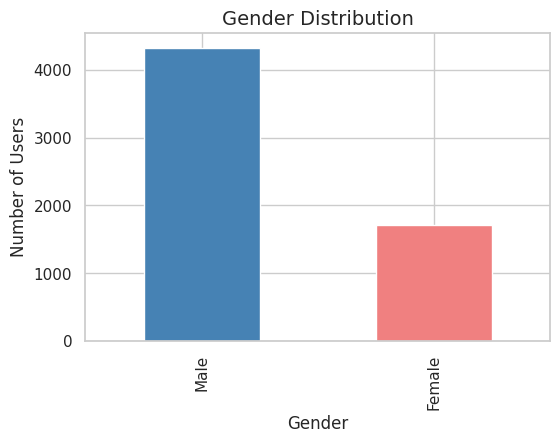

In [6]:
# Distribution des utilisateurs par Sexe
gender_counts = df_users.groupby("Gender")["UserID"].nunique().rename({1: "Female", 0: "Male"})
print(gender_counts)

print(" ")
print(f"There are {gender_counts["Male"]/(gender_counts['Female']+gender_counts["Male"])*100}% men in the dataset")

plt.figure(figsize=(6, 4))
gender_counts.plot(kind="bar", color=["steelblue", "lightcoral"])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.show()

/tmp/ipykernel_178020/2536800450.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_users.drop_duplicates('UserID'), x='AgeGroup', order=age_order, palette="viridis")


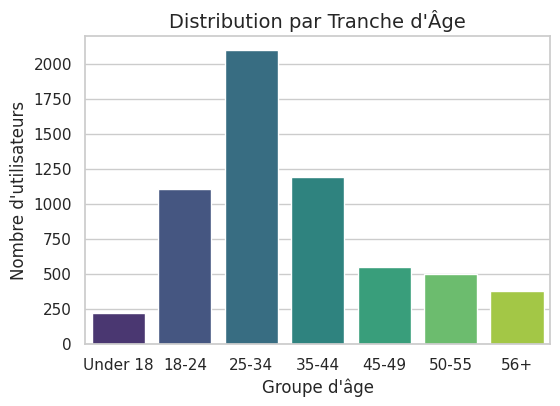

In [7]:
# Distribution par Tranche d'Âge
age_map = {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"}
df_users['AgeGroup'] = df_users['Age'].map(age_map)
age_order = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]

plt.figure(figsize=(6, 4))
sns.countplot(data=df_users.drop_duplicates('UserID'), x='AgeGroup', order=age_order, palette="viridis")
plt.title("Distribution par Tranche d'Âge")
plt.xlabel("Groupe d'âge")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

**Quelques conclusions :** 
* Déséquilibre Homme/Femme : Le jeu de données présente une majorité d'utilisateurs masculins (environ 71.7%).

* Prédominance des jeunes adultes : La tranche d'âge la plus représentée est celle des 25-34 ans, suivie par les 18-24 ans. Cela indique que la base de données reflète principalement les goûts d'une population jeune et active au moment de la collecte.

### Les films 

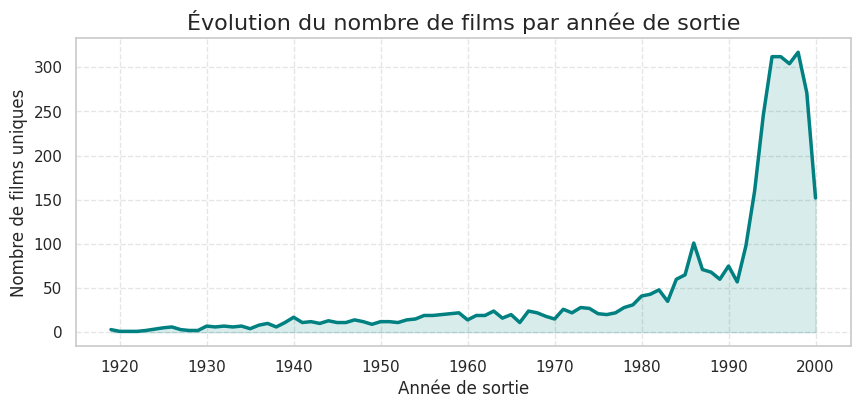

In [8]:
# Distribution des films par année
df_unique_films = df_users.drop_duplicates('MovieID')

# Comptage des films par année
films_par_an = df_unique_films['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x=films_par_an.index, y=films_par_an.values, color='teal', linewidth=2.5)
plt.fill_between(films_par_an.index, films_par_an.values, color='teal', alpha=0.15)

plt.title("Évolution du nombre de films par année de sortie", fontsize=16)
plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films uniques", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Les notes des utilisateurs 

/tmp/ipykernel_178020/4040737625.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette="magma")


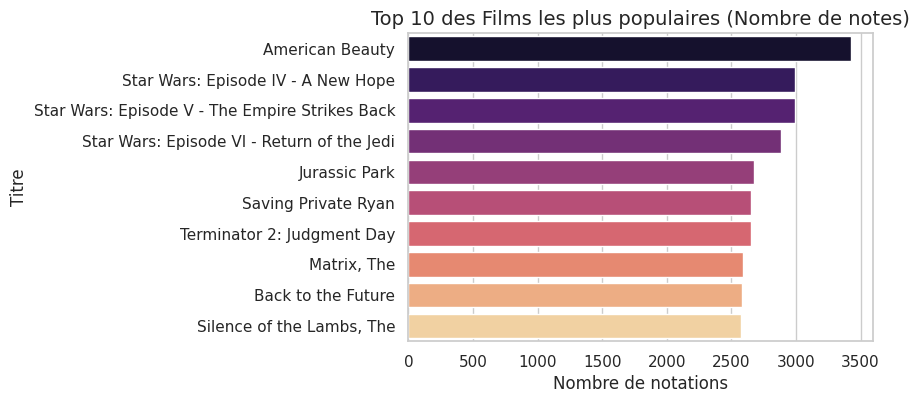

In [9]:
# Top 10 des Films les plus notés
plt.figure(figsize=(6,4))
top_movies = df_users['Title'].value_counts().head(10)
sns.barplot(x=top_movies.values, y=top_movies.index, palette="magma")
plt.title("Top 10 des Films les plus populaires (Nombre de notes)")
plt.ylabel("Titre")
plt.xlabel("Nombre de notations")
plt.show()

/tmp/ipykernel_178020/1110914447.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df_users, palette="crest")


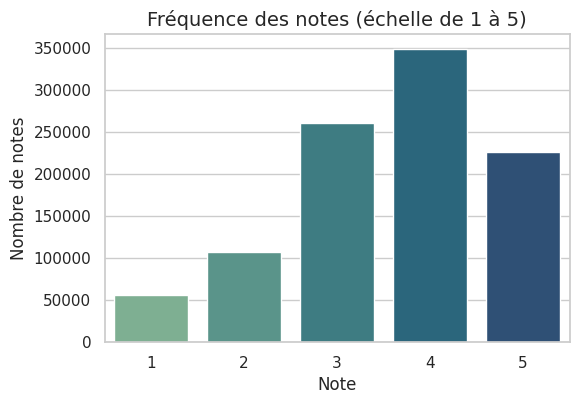

In [10]:
# 4. Distribution des Notes attribuées
plt.figure(figsize=(6,4))
sns.countplot(x='Rating', data=df_users, palette="crest")
plt.title("Fréquence des notes (échelle de 1 à 5)")
plt.xlabel("Note")
plt.ylabel("Nombre de notes")
plt.show()

/tmp/ipykernel_178020/3557259146.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=moyennes_globales, x='Sexe', y='Rating', palette=['#5dade2', '#ec7063'])


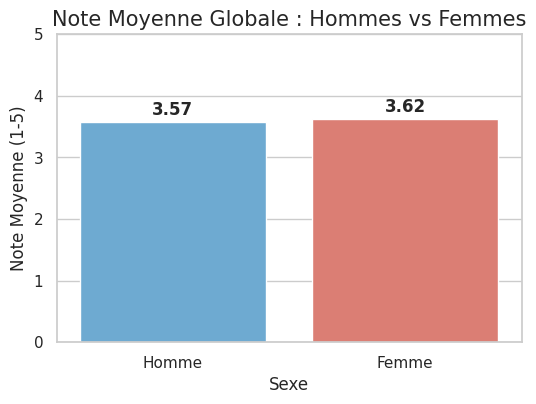

In [11]:
# Notes moyennes par sexe 

# 0 = Male, 1 = Female 
moyennes_globales = df_users.groupby('Gender')['Rating'].mean().reset_index()
moyennes_globales['Sexe'] = moyennes_globales['Gender'].map({0: 'Homme', 1: 'Femme'})

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=moyennes_globales, x='Sexe', y='Rating', palette=['#5dade2', '#ec7063'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.title("Note Moyenne Globale : Hommes vs Femmes", fontsize=15)
plt.ylabel("Note Moyenne (1-5)", fontsize=12)
plt.xlabel("Sexe", fontsize=12)
plt.ylim(0, 5)
plt.show()

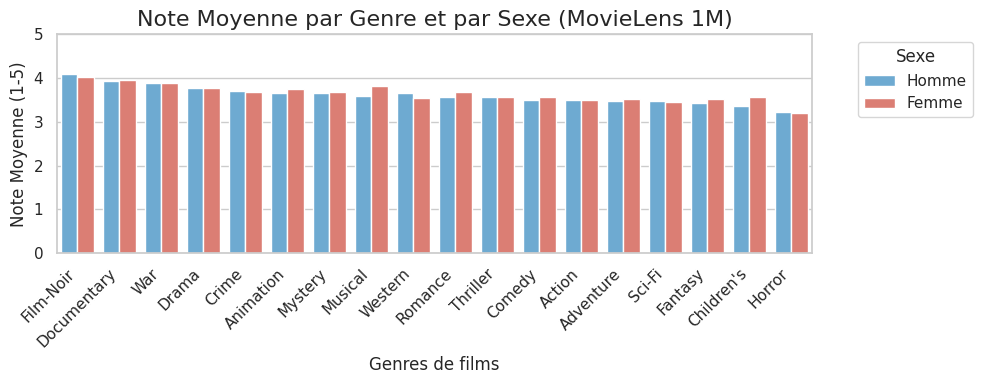

In [12]:
# Préférences : Notes moyennes par genre et pas sexe 
# Explode the genres 
df_exploded = df_users.explode("Genres")

# Calculating the average rating per genre 
stats_moyennes = df_exploded.groupby(["Genres", "Gender"])["Rating"].mean().reset_index()

stats_moyennes["Sexe"] = stats_moyennes["Gender"].map({0: "Homme", 1: "Femme"})

# Rank the genres by total average rating
ordre_genres = df_exploded.groupby("Genres")["Rating"].mean().sort_values(ascending=False).index

# Plotting
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    data=stats_moyennes,
    x="Genres",
    y="Rating",
    hue="Sexe",
    palette=["#5dade2", "#ec7063"], 
    order=ordre_genres
)

plt.title("Note Moyenne par Genre et par Sexe (MovieLens 1M)", fontsize=16)
plt.xlabel("Genres de films", fontsize=12)
plt.ylabel("Note Moyenne (1-5)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 5) 
plt.legend(title="Sexe", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

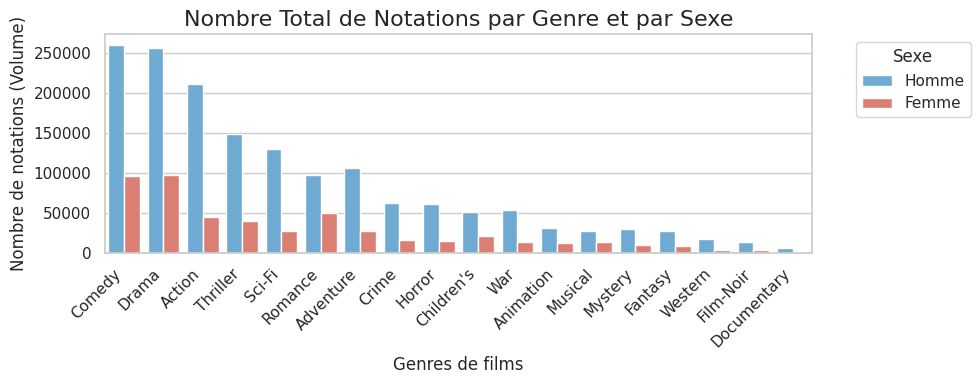

In [13]:
# Analyse des Volumes : Comptage des notations par genre et par sexe
df_exploded = df_users.explode("Genres")

stats_comptage = df_exploded.groupby(["Genres", "Gender"]).size().reset_index(name='Nombre de Notations')

stats_comptage["Sexe"] = stats_comptage["Gender"].map({0: "Homme", 1: "Femme"})

ordre_popularite = df_exploded['Genres'].value_counts().index

# Visualisation
plt.figure(figsize=(10, 4))
sns.barplot(
    data=stats_comptage,
    x="Genres",
    y="Nombre de Notations",
    hue="Sexe",
    palette=["#5dade2", "#ec7063"], 
    order=ordre_popularite
)

plt.title("Nombre Total de Notations par Genre et par Sexe", fontsize=16)
plt.xlabel("Genres de films", fontsize=12)
plt.ylabel("Nombre de notations (Volume)", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.legend(title="Sexe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Quelques conclusions :**

**Comportement de Notation :** La note 4 est la plus fréquente. La popularité est concentrée sur quelques blockbusters.

**Préférences par Genre :**
* Les genres Film-Noir, War et Documentary obtiennent les meilleures notes moyennes globales (souvent supérieures à 4/5) pour les deux sexes.
* Les hommes mettent des notes moyennes plus basses sur des genres comme Romance ou Musical. 

Par la suite, nous allons nous concentrer surtout sur les genres. Les données démographiques (sexe, âge, code postal) servent à vérifier la représentativité de l'échantillon mais ne sont pas incluses dans les modèle de filtrage collaboratif et content-based. Ces modèles reposent exclusivement sur les interactions passées pour prédire les goûts futurs.

## 3). Modelling : Approche par Filtrage Collaboratif

In [14]:
!pip install torch torchvision torchaudio

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### 3.1). Préparation des matrices de données Y et R

Pour implémenter l'algorithme de filtrage collaboratif, nous devons d'abord transformer nos données sous forme matricielle :

- $Y$ est une matrice de dimensions $(n_m \times n_u)$ contenant les notes, où $n_m$ est le nombre de films et $n_u$ le nombre d'utilisateurs.

- $R$ est une matrice binaire de même dimension, où $R(i,j)=1$ si l'utilisateur $j$ a noté le film $i$, et $0$ sinon.

La prédiction d'une note est définie par le produit scalaire des vecteurs de caractéristiques :

$$
\text{Note Prédite}(i,j) = x^{(i)} \cdot w^{(j)} + b^{(j)}
$$


In [16]:
# Création de la matrice de notes Y (Films en lignes, Utilisateurs en colonnes)
Y_df = df_users.pivot_table(index='MovieID', columns='UserID', values='Rating').fillna(0)
Y_matrix = Y_df.values
R_matrix = (Y_matrix > 0).astype(int)

# Conversion en tenseurs PyTorch pour le calcul manuel
Y = torch.tensor(Y_matrix, dtype=torch.float32)
R = torch.tensor(R_matrix, dtype=torch.float32)

num_movies, num_users = Y.shape
num_features = 200  # Nombre de caractéristiques latentes (nf)

### 3.2). Initialisation manuelle des paramètres 

Nous initialisons directement les matrices de paramètres que nous allons apprendre par descente de gradient :

- $X$ : matrice des caractéristiques des films de dimension $(n_m \times n_f)$.

- $W$ : matrice des préférences des utilisateurs de dimension $(n_u \times n_f)$.

- $b$ : vecteur de biais des utilisateurs de dimension $(1 \times n_u)$.

Nous activons `requires_grad=True` pour permettre à PyTorch de suivre ces tenseurs et de calculer automatiquement les gradients de la fonction de coût par rapport à chacun d'eux.


In [17]:
# Initialisation aléatoire des tenseurs
X = torch.randn(num_movies, num_features, requires_grad=True)
W = torch.randn(num_users, num_features, requires_grad=True)
b = torch.randn(1, num_users, requires_grad=True)

# Optimiseur Adam pour mettre à jour nos matrices X, W et b
optimizer = torch.optim.Adam([X, W, b], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)

**Résumé des matrices créées :**


| Paramètre | Symbole | Taille | Description |
| :--- | :--- | :--- | :--- |
| **Caractéristiques Films** | $\mathbf{X}$ | $(\text{nm} \times \text{nf})$ | $nm$: Nombre de films (3706). $nf$: Nombre de caractéristiques (200). |
| **Paramètres Utilisateurs** | $\mathbf{W}$ | $(\text{nu} \times \text{nf})$ | $nu$: Nombre d'utilisateurs (6040). $nf$: Nombre de caractéristiques (200). |
| **Biais Utilisateurs** | $\mathbf{b}$ | $(1 \times \text{nu})$ | Ajustement de la note pour chaque utilisateur. |

### 3.3). Implémentation de la fonction de coût $J$

La fonction de coût mesure l'erreur entre les notes réelles et nos prédictions, avec l'ajout d'une régularisation $L_2$ pour éviter le surapprentissage :

$$
J(X, W, b) =
\frac{1}{2}
\sum_{(i,j):\,R(i,j)=1}
\left( x^{(i)} \cdot w^{(j)} + b^{(j)} - y(i,j) \right)^2
+
\frac{\lambda}{2}
\sum_{j} \|w^{(j)}\|^2
+
\frac{\lambda}{2}
\sum_{i} \|x^{(i)}\|^2
$$

Cette fonction est implémentée de manière vectorisée pour optimiser les performances de calcul.


In [18]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    # Calcul de toutes les prédictions : (X @ W.t()) + b
    # Shape résultante : (num_movies, num_users)
    predictions = (X @ W.t()) + b
    
    # Calcul de l'erreur uniquement là où R(i,j) == 1
    diff = (predictions - Y) * R
    
    # Terme d'erreur quadratique
    cost = 0.5 * torch.sum(diff**2)
    
    # Termes de régularisation L2
    reg = (lambda_ / 2) * (torch.sum(X**2) + torch.sum(W**2))
    
    return cost + reg

### 3.4). Processus d'optimisation par descente de gradient

Nous exécutons manuellement la boucle d'entraînement. À chaque itération :

- Nous calculons la perte (*loss*) via la fonction de coût.

- Nous appelons `loss.backward()` pour générer les gradients par rapport à $X$, $W$ et $b$.

- Nous mettons à jour les paramètres via `optimizer.step()`.


In [19]:
iterations = 500
lambda_reg = 0.01

print("Début de l'entraînement manuel...")
for i in range(iterations):
    # Remise à zéro des gradients
    optimizer.zero_grad()
    
    # Calcul du coût
    loss = cofi_cost_func(X, W, b, Y, R, lambda_reg)
    
    # Calcul automatique des gradients
    loss.backward()
    
    # Mise à jour des paramètres X, W et b
    optimizer.step()
    scheduler.step()
    
    if i % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Itération {i} : Coût = {loss.item():.2f}, Learning rate : {current_lr}")

Début de l'entraînement manuel...
Itération 0 : Coût = 106875136.00, Learning rate : 0.1
Itération 20 : Coût = 1678286.62, Learning rate : 0.1
Itération 40 : Coût = 343629.09, Learning rate : 0.05
Itération 60 : Coût = 196107.64, Learning rate : 0.05
Itération 80 : Coût = 154038.55, Learning rate : 0.025
Itération 100 : Coût = 142190.12, Learning rate : 0.025
Itération 120 : Coût = 132879.77, Learning rate : 0.0125
Itération 140 : Coût = 128673.66, Learning rate : 0.0125
Itération 160 : Coût = 124604.77, Learning rate : 0.00625
Itération 180 : Coût = 122595.33, Learning rate : 0.00625
Itération 200 : Coût = 120568.62, Learning rate : 0.003125
Itération 220 : Coût = 119539.98, Learning rate : 0.003125
Itération 240 : Coût = 118486.73, Learning rate : 0.0015625
Itération 260 : Coût = 117946.39, Learning rate : 0.0015625
Itération 280 : Coût = 117389.95, Learning rate : 0.00078125
Itération 300 : Coût = 117103.34, Learning rate : 0.00078125
Itération 320 : Coût = 116807.75, Learning rate 

### 3.5). Génération des recommandations

Une fois les matrices $X$, $W$ et le biais $b$ optimisés, nous pouvons prédire la note pour n'importe quel film $i$ et utilisateur $j$ en calculant simplement :

$$
\hat{Y} = X W^{\mathsf{T}} + b
$$

Ces prédictions nous permettent de recommander les films ayant les notes prédites les plus élevées que l'utilisateur n'a pas encore vus.


In [20]:
def voir_comparaison_utilisateur(user_id, X, W, b, Y_matrix, movieList, k=10):
    # On récupère les paramètres optimisés pour cet utilisateur
    with torch.no_grad():
        # Prédiction pour l'utilisateur spécifique : X @ w_j.t() + b_j
        # W[user_id] est de taille (nf,), on le reshape pour le produit matriciel
        w_user = W[user_id].reshape(1, -1)
        b_user = b[0, user_id]
        user_preds = (X @ w_user.t()) + b_user
        user_preds = user_preds.numpy().flatten()

    # Trouver les indices des films que l'utilisateur a réellement notés
    rated_indices = np.where(Y_matrix[:, user_id] > 0)[0]
    
    print(f"--- Comparaison des notes pour l'utilisateur ID: {user_id} ---")
    print(f"{'Film':<50} | {'Réelle':<7} | {'Prédite':<7}")
    print("-" * 70)
    
    for idx in rated_indices[:k]: # On affiche les k premiers
        print(f"{movieList[idx][:50]:<50} | {Y_matrix[idx, user_id]:<7.1f} | {user_preds[idx]:<7.2f}")

# Utilisation
movie_titles_df = df_users[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')
movieList = [movie_titles_df.loc[mid, 'Title'] for mid in Y_df.index]
voir_comparaison_utilisateur(2, X, W, b, Y_matrix, movieList)

--- Comparaison des notes pour l'utilisateur ID: 2 ---
Film                                               | Réelle  | Prédite
----------------------------------------------------------------------
Happy Gilmore                                      | 4.0     | 4.28   
Star Wars: Episode IV - A New Hope                 | 5.0     | 4.82   
Jurassic Park                                      | 4.0     | 3.81   
Three Musketeers, The                              | 4.0     | 4.00   
Dances with Wolves                                 | 4.0     | 4.00   
Silence of the Lambs, The                          | 3.0     | 3.06   
Mission: Impossible                                | 3.0     | 3.02   
Dragonheart                                        | 4.0     | 3.89   
Rock, The                                          | 5.0     | 4.90   
Ghost and the Darkness, The                        | 4.0     | 4.05   


### 3.7). Recommandation pour un nouvel utilisateur

Lorsqu'un nouvel utilisateur arrive, nous ne connaissons pas son vecteur de préférences $w_{\text{new}}$. Au lieu de réentraîner tout le modèle, nous utilisons une approche d'optimisation locale :

- Nous fixons la matrice des caractéristiques des films $X$ (déjà apprise).

- Nous initialisons un nouveau vecteur $w_{\text{new}}$ et un biais $b_{\text{new}}$.

- Nous optimisons uniquement ces deux paramètres pour minimiser l'erreur sur les quelques films notés par ce nouvel utilisateur :

$$
J_{\text{new}}(w_{\text{new}}, b_{\text{new}})
=
\frac{1}{2}
\sum_{i:\,R(i)=1}
\left( x^{(i)} \cdot w_{\text{new}} + b_{\text{new}} - y(i) \right)^2
+
\frac{\lambda}{2}
\lVert w_{\text{new}} \rVert^2
$$


In [22]:
def k_recommendations_cofi(movie_index, X_trained, movieList, k=5):
    """
    Trouve les k films les plus similaires à un film donné en utilisant 
    la similarité cosinus sur les vecteurs latents X.

    cofi : collaborative filtering
    """
    with torch.no_grad():
        # Extraction du vecteur du film cible
        v_cible = X_trained[movie_index].reshape(1, -1)
        
        # Calcul de la similarité cosinus entre le film cible et tous les autres
        # F.cosine_similarity(x1, x2) calcule la similarité sur la dimension spécifiée
        similarites = F.cosine_similarity(v_cible, X_trained)
        
    # On récupère les indices des films les plus similaires (tri décroissant)
    indices_proches = torch.argsort(similarites, descending=True)
    
    print(f"\n--- Films les plus proches de : {movieList[movie_index]} ---")
    count = 0
    for idx in indices_proches:
        # On ignore le film lui-même
        if idx.item() == movie_index:
            continue
            
        print(f"Score de similarité: {similarites[idx].item():.4f} | Film: {movieList[idx]}")
        count += 1
        if count == k:
            break

# --- Exemple d'utilisation ---

# 1. On cherche d'abord les infos sur le film
# On suppose que movieIDs est une liste des MovieID correspondant à movieList
movieIDs = Y_df.index.tolist()
recherches = search_films("Toy Story", movieList, movieIDs)

# 2. Si on a trouvé le film, on cherche les meilleurs ajustements pour le premier résultat
if recherches:
    target_idx = recherches[0]['index']
    k_recommendations_cofi(target_idx, X.detach(), movieList, k=5)

Correspondances pour 'Toy Story':
  - ID: 1 | Titre: Toy Story
  - ID: 3114 | Titre: Toy Story 2

--- Films les plus proches de : Toy Story ---
Score de similarité: 0.6247 | Film: Matrix, The
Score de similarité: 0.5979 | Film: Toy Story 2
Score de similarité: 0.5865 | Film: Star Trek: First Contact
Score de similarité: 0.5699 | Film: Twelve Monkeys
Score de similarité: 0.5596 | Film: Beauty and the Beast


## 4). Modelling : content-based filtering

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### 4.1). Preparing the data

In [24]:
# 1. Prepare genres: Ensure they are lists and explode
df_exploded = df_users.copy()
df_exploded['Genres'] = df_exploded['Genres'].apply(lambda x: x if isinstance(x, list) else [])
df_exploded = df_exploded.explode('Genres')

# Remove any empty genre strings if they exist
df_exploded = df_exploded[df_exploded['Genres'] != ""]

# 2. Calculate average rating per user per genre
user_genre_ave = df_exploded.pivot_table(
    index='UserID', 
    columns='Genres', 
    values='Rating', 
    aggfunc='mean'
).fillna(0.0)

# 3. Calculate total ratings and global average per user
user_stats = df_users.groupby('UserID')['Rating'].agg(['count', 'mean']).rename(
    columns={'mean': 'rating ave', 'count': 'rating count'}
)

# 4. Final User Table
user_table = user_stats.join(user_genre_ave)

print("--- User Table ---")
display(user_table.head())

--- User Table ---


,rating count,rating ave,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,,,
1,53,4.188679,4.200000,4.000000,4.111111,4.250000,4.142857,4.000000,0.000000,4.428571,4.0,0.0,0.000000,4.285714,0.000000,3.666667,4.333333,3.666667,5.000000,0.000000
2,129,3.713178,3.500000,3.736842,0.000000,0.000000,3.560000,3.583333,0.000000,3.898734,3.0,4.0,3.000000,0.000000,3.333333,3.708333,3.588235,3.483871,3.733333,4.333333
3,51,3.901961,3.956522,4.000000,4.000000,4.000000,3.766667,0.000000,0.000000,4.000000,4.5,0.0,2.666667,4.000000,3.000000,3.800000,3.833333,3.800000,4.000000,4.666667
4,21,4.190476,4.157895,3.833333,0.000000,4.000000,0.000000,5.000000,0.000000,4.166667,4.5,0.0,4.333333,0.000000,0.000000,4.000000,3.555556,3.500000,3.333333,4.500000
5,198,3.146465,2.612903,3.000000,4.000000,3.833333,3.410714,3.285714,3.666667,3.096154,0.0,4.0,2.800000,3.333333,3.125000,3.100000,3.066667,2.846154,3.500000,4.000000


In [25]:
# 2. Calculate average rating per movie
movie_stats = df_users.groupby('MovieID')['Rating'].mean().rename('ave rating')

# 3. Create genre flags with 0 and 1
genre_flags = pd.get_dummies(
    df_exploded.set_index('MovieID')['Genres'], 
    dtype=int
).groupby('MovieID').max()

# 4. Combine with title and year
movie_info = df_users[['MovieID', 'Title', 'Year']].drop_duplicates().set_index('MovieID')
movie_table = movie_info.join(movie_stats).join(genre_flags)

print("\n--- Movie Tabl ---")
display(movie_table.head())


--- Movie Tabl ---


,Title,Year,ave rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,,,,
1193,One Flew Over the Cuckoo's Nest,1975.0,4.390725,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,James and the Giant Peach,1996.0,3.464762,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
914,My Fair Lady,1964.0,4.154088,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3408,Erin Brockovich,2000.0,3.863878,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2355,"Bug's Life, A",1998.0,3.854375,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# We need a row for every rating in the original dataset
# Each row contains: User features, Movie features, Target Rating
merged_data = df_users[['UserID', 'MovieID', 'Rating']].copy()

# Join user features
user_vecs = merged_data[['UserID']].merge(user_table, left_on='UserID', right_index=True).drop(columns=['UserID', 'rating count', 'rating ave']).values
# Join movie features
movie_vecs = merged_data[['MovieID']].merge(movie_table, left_on='MovieID', right_index=True).drop(columns=['MovieID', 'Title']).values
# Targets
y_vecs = merged_data['Rating'].values.reshape(-1, 1)

In [27]:
print(y_vecs.shape)
print(user_vecs.shape)
print(movie_vecs.shape)

(1000209, 1)
(1000209, 18)
(1000209, 20)


In [28]:
# Scaling the data 
import joblib
import os

# Chemins pour les scalers
scaler_user_path = 'scaler_user.joblib'
scaler_item_path = 'scaler_item.joblib'
scaler_target_path = 'scaler_target.joblib'

# Si les fichiers existent, on les charge, sinon on les entraîne
if os.path.exists(scaler_user_path):
    scalerUser = joblib.load(scaler_user_path)
    scalerItem = joblib.load(scaler_item_path)
    scalerTarget = joblib.load(scaler_target_path)
    user_train_scaled = scalerUser.transform(user_vecs) # On utilise transform au lieu de fit_transform
    item_train_scaled = scalerItem.transform(movie_vecs)
    y_train_scaled = scalerTarget.transform(y_vecs.reshape(-1, 1))
    print("Scalers chargés depuis le disque.")
else:
    scalerUser = StandardScaler()
    user_train_scaled = scalerUser.fit_transform(user_vecs)

    scalerItem = StandardScaler()
    item_train_scaled = scalerItem.fit_transform(movie_vecs)

    scalerTarget = StandardScaler()
    y_train_scaled = scalerTarget.fit_transform(y_vecs.reshape(-1, 1))
    
    # Sauvegarde
    joblib.dump(scalerUser, scaler_user_path)
    joblib.dump(scalerItem, scaler_item_path)
    joblib.dump(scalerTarget, scaler_target_path)
    print("Scalers entraînés et sauvegardés.")

Scalers entraînés et sauvegardés.


In [29]:
# --- 3. SPLIT THE DATA (80/20) ---
user_train, user_test, item_train, item_test, y_train, y_test = train_test_split(
    user_train_scaled, item_train_scaled, y_train_scaled, 
    test_size=0.20, shuffle=True, random_state=1
)

### 4.2). Creating the dataloaders

In [30]:
class RecSysDataset(Dataset):
    def __init__(self, user_data, item_data, target_data):
        self.user_data = torch.tensor(user_data, dtype=torch.float32)
        self.item_data = torch.tensor(item_data, dtype=torch.float32)
        self.targets = torch.tensor(target_data, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.user_data[idx], self.item_data[idx], self.targets[idx]

# Create DataLoaders
train_dataset = RecSysDataset(user_train, item_train, y_train)
test_dataset = RecSysDataset(user_test, item_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Identify feature counts for your model
num_user_features = user_train.shape[1]
num_item_features = item_train.shape[1]

print(f"Num User Features: {num_user_features}")
print(f"Num Item Features: {num_item_features}")

Num User Features: 18
Num Item Features: 20


In [31]:
# Checking the sizes 
user_batch, item_batch, y_batch = next(iter(train_loader))
print(user_batch.shape)
print(item_batch.shape)
print(y_batch.shape)

torch.Size([256, 18])
torch.Size([256, 20])
torch.Size([256, 1])


### 4.2). Creating the model

In [32]:
def createTheRecommenderNet(num_user_features, num_item_features, num_outputs=32): 

    class TwoTowerModel(nn.Module):
        def __init__(self, num_user_features, num_item_features, num_outputs):
            super(TwoTowerModel, self).__init__()
            
            # User Network
            self.user_nn = nn.Sequential(
                nn.Linear(num_user_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_outputs)
            )
            
            # Item Network
            self.item_nn = nn.Sequential(
                nn.Linear(num_item_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_outputs)
            )

        def forward(self, user_input, item_input):
            # Pass through networks
            vu = self.user_nn(user_input)
            vm = self.item_nn(item_input)
            
            # L2 Normalization: p=2 is the L2 norm, dim=1 is the feature axis
            vu = F.normalize(vu, p=2, dim=1)
            vm = F.normalize(vm, p=2, dim=1)
            
            # Dot product (batch-wise)
            # Using (vu * vm).sum(dim=1) or torch.bmm
            output = torch.sum(vu * vm, dim=1, keepdim=True)
            
            return output

    # create the model instance
    net = TwoTowerModel(num_user_features, num_item_features, num_outputs)
    
    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    return net,lossfun,optimizer,scheduler 


In [33]:
createTheRecommenderNet(num_user_features,num_item_features)

(TwoTowerModel(
   (user_nn): Sequential(
     (0): Linear(in_features=18, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=32, bias=True)
   )
   (item_nn): Sequential(
     (0): Linear(in_features=20, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=32, bias=True)
   )
 ),
 MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.StepLR at 0x7fbe1f3f5d10>)

In [34]:
# test the model with one batch
net,lossfun,optimizer, scheduler = createTheRecommenderNet(num_user_features, num_item_features)

user_batch, movie_batch, y_batch = next(iter(train_loader))
yHat = net(user_batch, movie_batch)

loss = lossfun(yHat,y_batch)
print(' ')
print('Loss:')
print(loss)


 
Loss:
tensor(1.0306, grad_fn=<MseLossBackward0>)


### 4.3). Training the model

In [ ]:

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer, scheduler = createTheRecommenderNet(num_user_features, num_item_features)

  # initialize losses
  losses    = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for user_vec, movie_vec, y in train_loader:

      # forward pass and loss
      yHat = net(user_vec, movie_vec)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses across the batches
    scheduler.step()
    epoch_loss = np.mean(batchLoss)
    losses[epochi] = epoch_loss
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epochi} is completed, the loss is {epoch_loss}, the learning rate is {current_lr}')
      
  # end epochs

  # function output
  return losses,net

In [36]:
model_path = 'content_based_model.pth'
force_train = False  # Changez à True si vous voulez absolument ré-entraîner le modèle

# Initialisation de l'architecture (indispensable pour charger les poids)
net, lossfun, optimizer, scheduler = createTheRecommenderNet(num_user_features, num_item_features)

if os.path.exists(model_path) and not force_train:
    print("Chargement des poids du modèle sauvegardé...")
    # Charger les poids dans l'instance 'net'
    net.load_state_dict(torch.load(model_path))
    net.eval() # Mode évaluation
    print("Modèle prêt à l'emploi (entraînement sauté) !")
else:
    print("Aucun modèle trouvé ou force_train=True. Lancement de l'entraînement (30 min)...")
    losses, net = function2trainTheModel()
    # Sauvegarde des poids après l'entraînement
    torch.save(net.state_dict(), model_path)
    print(f"Modèle entraîné et sauvegardé sous {model_path}")

Aucun modèle trouvé ou force_train=True. Lancement de l'entraînement (30 min)...
Epoch0 is completed, the loss is 0.6672522354720879, the learning rate is 0.001
Epoch1 is completed, the loss is 0.6554794553583887, the learning rate is 0.001
Epoch2 is completed, the loss is 0.6518970768820073, the learning rate is 0.0005
Epoch3 is completed, the loss is 0.6465520817293087, the learning rate is 0.0005
Epoch4 is completed, the loss is 0.6451323534995412, the learning rate is 0.0005
Epoch5 is completed, the loss is 0.6438541111374847, the learning rate is 0.00025
Epoch6 is completed, the loss is 0.6411146796233976, the learning rate is 0.00025
Epoch7 is completed, the loss is 0.640314699716089, the learning rate is 0.00025
Epoch8 is completed, the loss is 0.6398282839332112, the learning rate is 0.000125
Epoch9 is completed, the loss is 0.638222431448203, the learning rate is 0.000125
Modèle entraîné et sauvegardé sous content_based_model.pth


###  4.4). Generating predictions 

In [38]:
def recommend_content_based_new_user(user_ratings_dict, net, movie_table, scalerUser, scalerItem, scalerTarget, k=10):
    """
    user_ratings_dict: e.g., {"Casablanca (1942)": 5.0, "Toy Story (1995)": 1.0}
    """
    net.eval()
    
    # 1. Map ratings to MovieIDs to find genres
    # Note: movie_table index is MovieID
    genre_cols = movie_table.columns[3:] # Action, Adventure, etc.
    user_genre_ratings = {g: [] for g in genre_cols}
    rated_movie_ids = []

    for title, rating in user_ratings_dict.items():
        # Find MovieID for title
        match = movie_table[movie_table['Title'] == title]
        if match.empty:
            print(f"Movie '{title}' not found in database.")
            continue
        
        m_id = match.index[0]
        rated_movie_ids.append(m_id)
        
        # Check which genres this movie has and append the rating
        for g in genre_cols:
            if match.iloc[0][g] == 1:
                user_genre_ratings[g].append(rating)

    # 2. Construct the user feature vector (18 features: 0 or average per genre)
    # Based on your user_table logic: [Action, Adventure, ..., Western]
    user_features = []
    for g in genre_cols:
        if len(user_genre_ratings[g]) > 0:
            user_features.append(np.mean(user_genre_ratings[g]))
        else:
            user_features.append(0.0)
    
    user_vec = np.array(user_features).reshape(1, -1)
    
    # 3. Scale User Vector
    user_vec_scaled = scalerUser.transform(user_vec)
    user_tensor = torch.tensor(user_vec_scaled, dtype=torch.float32)

    # 4. Prepare Movie Features (All Movies)
    movie_features = movie_table.drop(columns=['Title', 'year', 'ave rating']).values
    movie_features_scaled = scalerItem.transform(movie_table.drop(columns=['Title']).values)
    movie_tensor = torch.tensor(movie_features_scaled, dtype=torch.float32)

    # 5. Predict
    with torch.no_grad():
        # Repeat user tensor to match number of movies
        u_expanded = user_tensor.repeat(movie_tensor.size(0), 1)
        preds_scaled = net(u_expanded, movie_tensor)
        preds = scalerTarget.inverse_transform(preds_scaled.numpy())

    # 6. Sort and Filter
    movie_table_copy = movie_table.copy()
    movie_table_copy['prediction'] = preds
    
    # Exclude movies already rated
    recommendations = movie_table_copy[~movie_table_copy.index.isin(rated_movie_ids)]
    top_k = recommendations.sort_values(by='prediction', ascending=False).head(k)

    print(f"\n--- Top {k} Content-Based Recommendations ---")
    for i, row in top_k.iterrows():
        print(f"Predicted: {row['prediction']:.2f} | {row['Title']}")
        
    return top_k

In [39]:
# Example of usage 
user_ratings_dict = {"10 Things I Hate About You": 5.0, "Emma": 5.0}
recommend_content_based_new_user(user_ratings_dict, net, movie_table, scalerUser, scalerItem, scalerTarget)


KeyError: "['year'] not found in axis"